## Evaluation of Experiments

In this notebook the experiments are evaluated according to the CVPRWS paper 
"Temporal Vegetation Modelling using Long Short-Term Memory Networks for Crop Identification from Medium-Resolution Multi-Spectral Satellite Images"

Set up envornmental variables:

In [1]:
import tensorflow as tf
import os
import re

###savedir stands for location of tensor models, see output train.py###
##opt: to load results by acocac,  first download the data using download_models.sh, models are saved in "acocac"
savedir = "acocac" 

networks = ['lstm', 'rnn', 'cnn']

l = [1,2,3]
r = [1,2,4,6]
f = [0,1,2,3,4]

dataset = "test"
rolling_mean_window = 10

def params2name(l,r,f):
    return "{}l{}r50d{}f".format(l,r,f)

def name2param(name):
    l,r,d,f = re.findall('\d+', name)
    return l,r,d,f

runs = [] # expected runs
for r_ in r:
    for l_ in l:
        for f_ in f:
            runs.append(params2name(l_,r_,f_))

extract data from Tensorflow event files:

In [2]:
def extract_from_eventfile(eventfile_path, tag='evaluation/accuracy'):
    steps = []
    values = []

    for e in tf.train.summary_iterator(eventfile_path):
        for v in e.summary.value:
            if v.tag == tag:
                steps.append(e.step)
                values.append(v.simple_value)

    return steps, values

def extract_from_all_eventfiles(path, tag='evaluation/accuracy'):
    """ 
    appends values from all event files in one folder
    if path does not exist: returns empty list
    """
    steps = []
    values = []
    
    if os.path.exists(path):
        eventfiles = os.listdir(path)
    else:
        return steps, values # empty

    for eventfile in eventfiles:
        steps_,values_ = extract_from_eventfile(os.path.join(path,eventfile), tag=tag)
        steps.extend(steps_)
        values.extend(values_)
        
    return steps, values

def gather_data_from_multiple_runs(folder_path, runs, dataset="test", tag='evaluation/accuracy'):
    """
    look through all save folders defined by runs, extract eventfiles from runs
    and append everything to pandas dataframe
    """

    series = []
    for run in runs:
        path = os.path.join(folder_path,run,dataset)
        steps,values = extract_from_all_eventfiles(path, tag)
        
        print("run: {} extracted {} values".format(run,len(values)))   

        if len(values) > 0:

            s = pd.Series(data=values, index=steps,name=run).sort_index()
            # drop duplicates
            s = s[~s.index.duplicated(keep='last')]

            #.drop_duplicates(keep='last')
            series.append(s)
            
    return pd.concat(series,axis=1,join="outer")

walk through all event files and extract cross entropy:

In [3]:
import pandas as pd
import numpy as np

def smooth_and_interpolate(data, rolling_mean_window = 10):
    data.interpolate(axis=1,inplace=True)
    return data.rolling(window=rolling_mean_window,axis=0).mean()

def get_best_run(data,max_is_better=False):
    scores = []
    for col in data.columns: 
        s = data[col]
        scores.append(s.loc[s.last_valid_index()])
    
    if max_is_better:
        return data.columns[np.array(scores).argmax()]
    else:
        return data.columns[np.array(scores).argmin()]

datasets = []
best_runs = []

# cross entropy
max_is_better = True
tag='evaluation/accuracy'
# for lstm/rnn/cnn
for network in networks: 
    print
    print network
    d = gather_data_from_multiple_runs(os.path.join(savedir,network),runs,dataset=dataset,tag=tag)
    best_runs.append(get_best_run(d, max_is_better))
    d = smooth_and_interpolate(d,rolling_mean_window)
    datasets.append(d)


lstm
run: 1l1r50d0f extracted 289 values
run: 1l1r50d1f extracted 289 values
run: 1l1r50d2f extracted 289 values
run: 1l1r50d3f extracted 289 values
run: 1l1r50d4f extracted 289 values
run: 2l1r50d0f extracted 289 values
run: 2l1r50d1f extracted 289 values
run: 2l1r50d2f extracted 289 values
run: 2l1r50d3f extracted 289 values
run: 2l1r50d4f extracted 289 values
run: 3l1r50d0f extracted 289 values
run: 3l1r50d1f extracted 289 values
run: 3l1r50d2f extracted 289 values
run: 3l1r50d3f extracted 289 values
run: 3l1r50d4f extracted 289 values
run: 1l2r50d0f extracted 289 values
run: 1l2r50d1f extracted 289 values
run: 1l2r50d2f extracted 289 values
run: 1l2r50d3f extracted 289 values
run: 1l2r50d4f extracted 289 values
run: 2l2r50d0f extracted 289 values
run: 2l2r50d1f extracted 289 values
run: 2l2r50d2f extracted 289 values
run: 2l2r50d3f extracted 289 values
run: 2l2r50d4f extracted 289 values
run: 3l2r50d0f extracted 289 values
run: 3l2r50d1f extracted 289 values
run: 3l2r50d2f extract

### best runs

In [4]:
for best_run, network in zip(best_runs, networks):
    print "Network {}: best run {}".format(network, best_run)

Network lstm: best run 1l4r50d2f
Network rnn: best run 1l2r50d2f
Network cnn: best run 1l6r50d1f


### Plot cross entropy over time for all networks

/home/acocac/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'Times'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


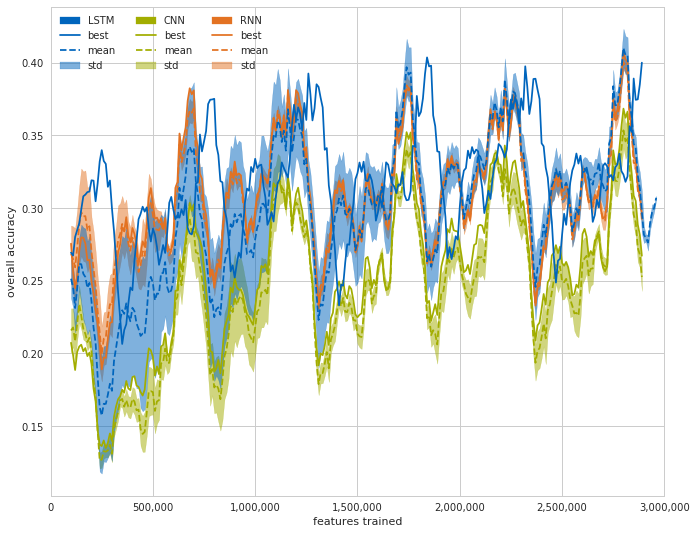

In [5]:
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch
from matplotlib.colors import rgb2hex
%matplotlib inline
import seaborn as sns
import numpy as np

sns.set(context='notebook', style='whitegrid', palette='deep', font='Times', font_scale=1, color_codes=False, rc=None)

tumivory = rgb2hex((218./255, 215./255, 203./255))

tumblue = rgb2hex((0., 101./255, 189./255))
tumgreen = rgb2hex((162./255, 173./255, 0))
tumorange = rgb2hex((227./255, 114./255, 34./255))

tumbluelight=rgb2hex((152./255, 198./255, 234./255))
tumbluemedium=rgb2hex((100./255, 160./255, 200./255))
tumbluedark=rgb2hex((0, 82./255, 147./255))

figsize=(11,9)
xlim = (0,3e6)

def plot_network_runs(data, ax=None, best_run = None, col="#cccccc", std_alpha=0.5, label="LSTM"):
    if ax is None:
        f, ax = plt.subplots()
    
    std = data.std(axis=1)
    
    patch = mpatches.Patch(color=col, label=label)
    
    mean = data.mean(axis=1)
    p_mean, = ax.plot(mean, color=col, linestyle="dashed", label="mean")
    
    p_best, = ax.plot(data[best_run], color=col, label="best")

    p_std = ax.fill_between(mean.index, mean-std, mean+std, where=mean+std >= mean-std, 
                            interpolate=True, color=col, alpha=std_alpha, label="std")
    
    
    
    # xlabels
    ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    ax.set_xlim(*xlim)
    
    return ax, [patch,p_best,p_mean,p_std], [mean, std, data[best_run]]
    
f, ax = plt.subplots(figsize=figsize)
ax, handles1, dat_cnn = plot_network_runs(datasets[2], 
                       ax=ax, 
                       best_run=best_runs[2], 
                       col=tumgreen, 
                       label="CNN")

ax, handles2, dat_rnn = plot_network_runs(datasets[1], 
                       ax=ax, 
                       best_run=best_runs[1], 
                       col=tumorange, 
                       label="RNN")

ax, handles0, dat_lstm = plot_network_runs(datasets[0], 
                       ax=ax, 
                       best_run=best_runs[0], 
                       col=tumblue, 
                       label="LSTM")


ax.legend(handles=handles0+handles1+handles2,ncol=len(networks))
ax.set_xlabel("features trained")
ax.set_ylabel("overall accuracy")

# uncomment to save
if False:
    f.savefig(pdf_filepath,transparent=True)

lstm = pd.DataFrame(dat_lstm, index=["mean", "std", "best"]).transpose()
rnn = pd.DataFrame(dat_rnn, index=["mean", "std", "best"]).transpose()
cnn = pd.DataFrame(dat_cnn, index=["mean", "std", "best"]).transpose()

### all networks

plot data from all networks

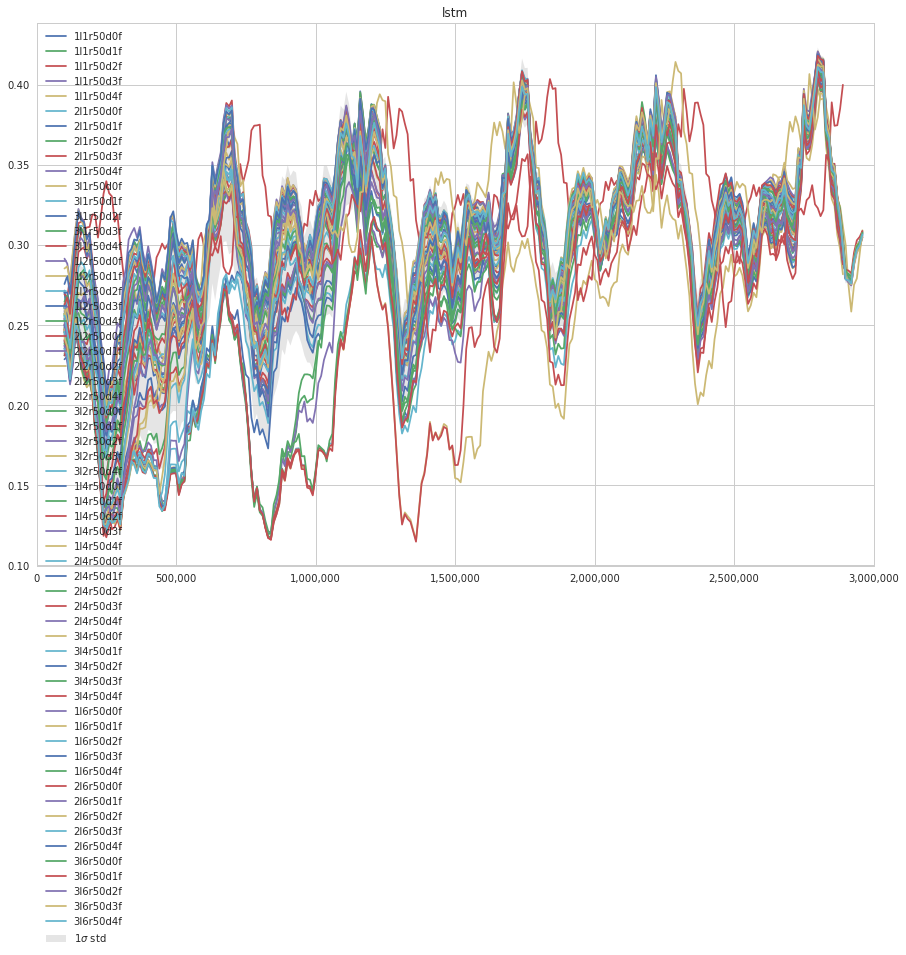

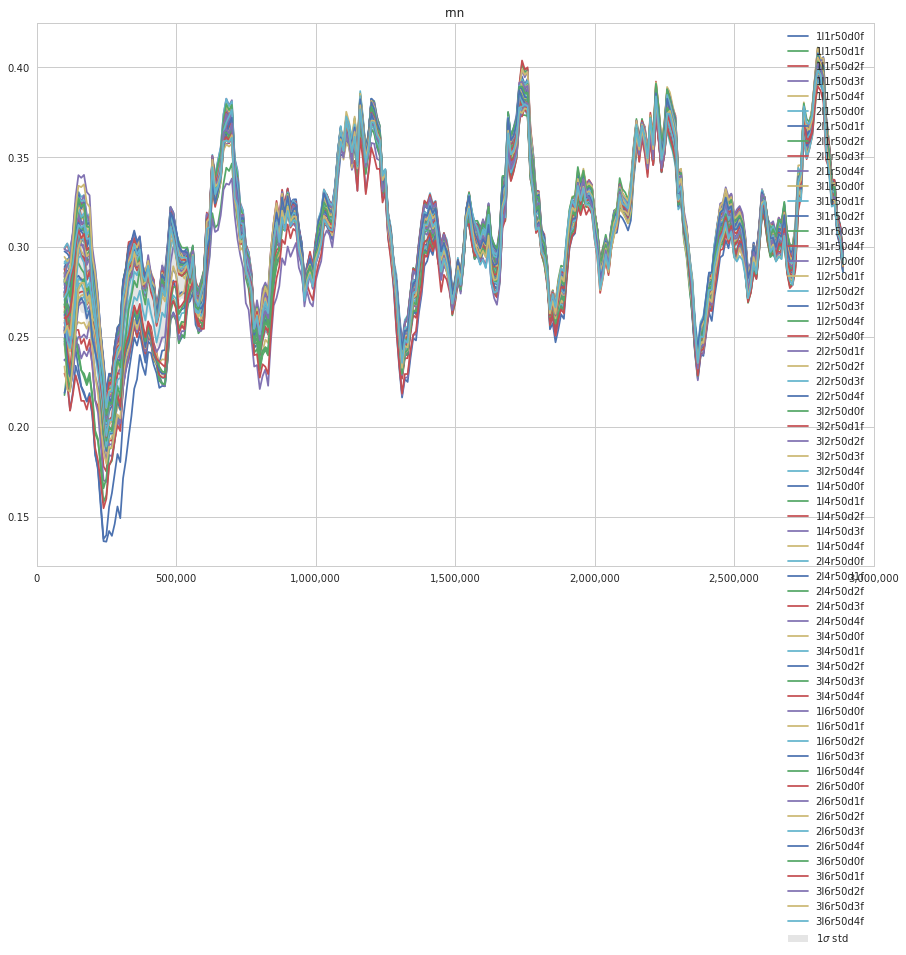

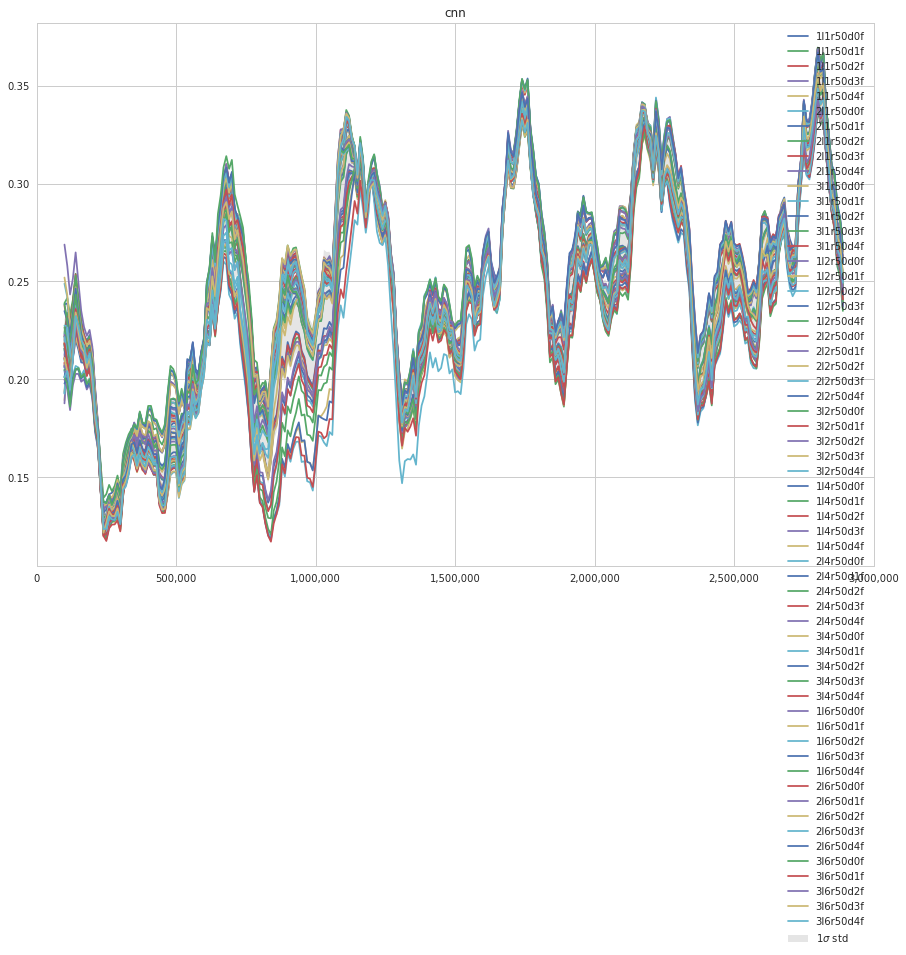

In [6]:
def plot_all_runs(data, ax=None, col="#cccccc", std_alpha=0.5, label_std=r"1$\sigma$ std", label="best run", title="title"):
    if ax is None:
        f, ax = plt.subplots()
    
    std = data.std(axis=1)
    mean = data.mean(axis=1)

    runs = data.columns
    for run in runs:
        ax.plot(data[run],label=run)

    ax.fill_between(mean.index, mean-std, mean+std, where=mean+std >= mean-std, interpolate=True, facecolor=col, alpha=std_alpha, label=label_std)
    
    # xlabels
    ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    ax.set_xlim(0,3e6)
    ax.set_title(title)
    
    return ax

figsize=(15,10)
for data, network in zip(datasets, networks):
    f, ax = plt.subplots(figsize=figsize)
    plot_all_runs(data, ax=ax, col="#cccccc", std_alpha=0.5, label_std=r"1$\sigma$ std", label="best run", title=network)
    ax.legend()

### Check completeness of training

Extract indeces of first event and last event for all networks to test if the networks have all trained completely

In [7]:
out = []
for run in runs:
    for network, data in zip(networks, datasets):
        if run in data.columns:
            col = data[run]
            first_valid = col.first_valid_index()
            last_valid = col.last_valid_index()
        else:
            first_valid = None
            last_valid = None
            
        out.append({"network":network, "run":run, "first_valid":first_valid, "last_valid":last_valid})


d = pd.DataFrame(out).set_index("run")
first_valid_by_network = d.pivot(columns='network', values='first_valid')
last_valid_by_network = d.pivot(columns='network', values='last_valid')

indices of first events for each network

In [8]:
first_valid_by_network

network,cnn,lstm,rnn
run,,,
1l1r50d0f,100000,100000,100000
1l1r50d1f,100000,100000,100000
1l1r50d2f,100000,100000,100000
1l1r50d3f,100000,100000,100000
1l1r50d4f,100000,100000,100000
1l2r50d0f,100000,100000,100000
1l2r50d1f,100000,100000,100000
1l2r50d2f,100000,100000,100000
1l2r50d3f,100000,100000,100000


indices of last event

In [9]:
last_valid_by_network

network,cnn,lstm,rnn
run,,,
1l1r50d0f,2890000,2890000,2890000
1l1r50d1f,2890000,2890000,2890000
1l1r50d2f,2890000,2890000,2890000
1l1r50d3f,2890000,2890000,2890000
1l1r50d4f,2890000,2890000,2890000
1l2r50d0f,2890000,2890000,2890000
1l2r50d1f,2890000,2890000,2890000
1l2r50d2f,2890000,2890000,2890000
1l2r50d3f,2890000,2890000,2890000


### Plots of LSTM layers
by number of layers l
and number if cells per layer r

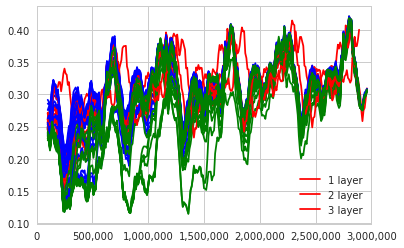

In [13]:
data = datasets[0]

colormapping = {1:"red", 2:"blue", 3:"green"}

def plot_by_l(data, colormapping, ax=None, cols=["red","blue","green"]):
    if ax is None:
        f, ax = plt.subplots()
    
    runs = data.columns
    for run in runs:
        l,r,d,f = name2param(run.split("/")[-1])
        col = colormapping[int(l)]
        ax.plot(data[run], color=col)
    
    # xlabels
    ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    ax.set_xlim(0,3e6)
    
    return ax

f, ax = plt.subplots()
plot_by_l(data, colormapping,ax=ax)
ax.legend(["1 layer","2 layer", "3 layer"])

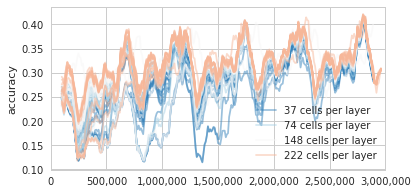

In [14]:
data = datasets[0]

cols = sns.color_palette("RdBu_r", n_colors=len(r)+1)

colormapping = dict(zip(r,cols))


def plot_by_r(data, colormapping, ax=None, cols=["blue","green","red"]):
    """
        Plot multilpe networks sorted by number of cells r
    """
    if ax is None:
        f, ax = plt.subplots()
    
    labels = ["{} cells per layer".format(r_*37) for r_ in colormapping.keys()]
    labels_map = dict(zip(colormapping.keys(),labels))
    
    
    runs = data.columns
    for run in runs:
        l,r,d,f = name2param(run.split("/")[-1])
        #print r
        col = colormapping[int(r)]
        ax.plot(data[run], color=col, label=labels_map[int(r)], alpha=0.5)
        labels_map[int(r)] = ""
    
    # xlabels
    ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    ax.set_ylabel("accuracy")
    
    ax.set_xlim(0,3e6)
    
    return ax

f, ax = plt.subplots(figsize=(6,3))
plot_by_r(data, colormapping,ax=ax)
ax.legend()